In [301]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [302]:
# Read in COVID19 data from csv
covid_data = pd.read_csv('./data/super_covid_data.csv')
covid_data.head()

,countyFIPS,County Name,State,StateFIPS,2020-01-22_cases,2020-01-23_cases,2020-01-24_cases,2020-01-25_cases,2020-01-26_cases,2020-01-27_cases,...,2023-07-15_deaths,2023-07-16_deaths,2023-07-17_deaths,2023-07-18_deaths,2023-07-19_deaths,2023-07-20_deaths,2023-07-21_deaths,2023-07-22_deaths,2023-07-23_deaths,population
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,235,235,235,235,235,235,235,235,235,55869
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,731,731,731,731,731,731,731,731,731,223234
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,104,104,104,104,104,104,104,104,104,24686
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,111,111,111,111,111,111,111,111,111,22394


In [303]:
# Save the first 4 columns and the last column as metadata for later
metadata_cols = covid_data.columns[:4].append(covid_data.columns[-1:])
metadata = covid_data[metadata_cols]

# Drop metadata columns from the original dataframe
covid_just_data = covid_data.drop(columns=metadata_cols)

In [304]:
# Filter to cases only and deaths only dataframes
covid_just_cases = covid_just_data[[col for col in covid_data_by_state.columns if 'cases' in col.lower()]]
covid_just_deaths = covid_just_data[[col for col in covid_data_by_state.columns if 'deaths' in col.lower()]]

In [305]:
# Remove '_cases' and '_deaths' from column titles
covid_just_cases.columns = [col.replace('_cases', '') for col in covid_just_cases.columns]
covid_just_deaths.columns = [col.replace('_deaths', '') for col in covid_just_deaths.columns]

In [306]:
# Convert column names to datetime objects
covid_just_cases.columns = [pd.to_datetime(col) for col in covid_just_cases.columns]
covid_just_deaths.columns = [pd.to_datetime(col) for col in covid_just_deaths.columns]

In [307]:
# Keep only the following date range: 2020-06-01 to 2021-01-03
start_date = pd.to_datetime('2020-06-01')
end_date = pd.to_datetime('2021-01-03')

covid_just_cases = covid_just_cases[[col for col in covid_just_cases.columns if start_date <= col <= end_date]]
covid_just_deaths = covid_just_deaths[[col for col in covid_just_deaths.columns if start_date <= col <= end_date]]

In [308]:
# Group by week (double transpose because axis=1 is apparently deprecated)
covid_just_cases_weekly = covid_just_cases.T.resample('W').sum().T
covid_just_deaths_weekly = covid_just_deaths.T.resample('W').sum().T

In [309]:
# add metadata back to the dataframes
covid_cases_weekly = pd.concat([metadata, covid_just_cases_weekly], axis=1)
covid_deaths_weekly = pd.concat([metadata, covid_just_deaths_weekly], axis=1)

In [310]:
def gen_stats(state_abbr, weekly_data, norm=1):
    state_weekly_data = weekly_data[weekly_data['State'] == state_abbr]
    state_pop = state_weekly_data['population'].sum()
    state_weekly_data = state_weekly_data.drop(columns=['State', 'StateFIPS', 'population', 'County Name', 'countyFIPS'])
    normalized_data = state_weekly_data.div(state_pop, axis=0) * norm
    stats = normalized_data.agg(['mean', 'median'])
    return stats.T

In [311]:
top_5_populous_states = covid_data.groupby('State')['population'].sum().sort_values(ascending=False).head().index
normalization_factor = 100000

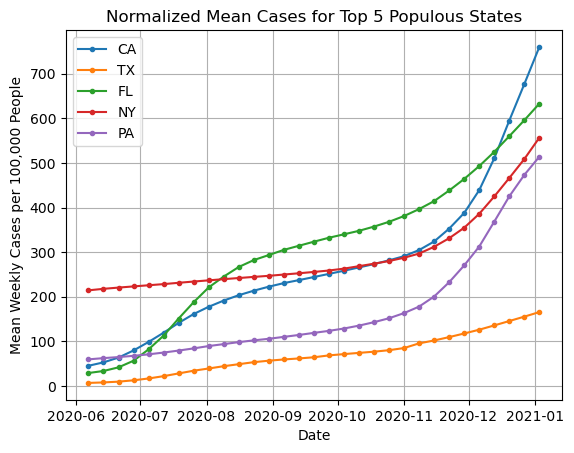

In [312]:
# Plot normalized mean cases for top 5 populous states
fig, ax = plt.subplots()
for state in top_5_populous_states:
    state_data = gen_stats(state, covid_cases_weekly, normalization_factor)
    ax.plot(state_data.index, state_data['mean'], label=state, marker='.')

ax.legend()
ax.title.set_text('Normalized Mean Cases for Top 5 Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Weekly Cases per 100,000 People')
ax.grid()
plt.show()

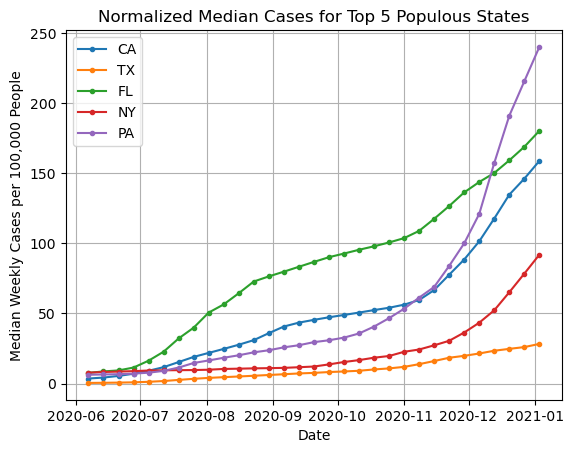

In [313]:
# Plot normalized median cases for top 5 populous states
fig, ax = plt.subplots()
for state in top_5_populous_states:
    state_data = gen_stats(state, covid_cases_weekly, normalization_factor)
    ax.plot(state_data.index, state_data['median'], label=state, marker='.')

ax.legend()
ax.title.set_text('Normalized Median Cases for Top 5 Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Median Weekly Cases per 100,000 People')
ax.grid()
plt.show()

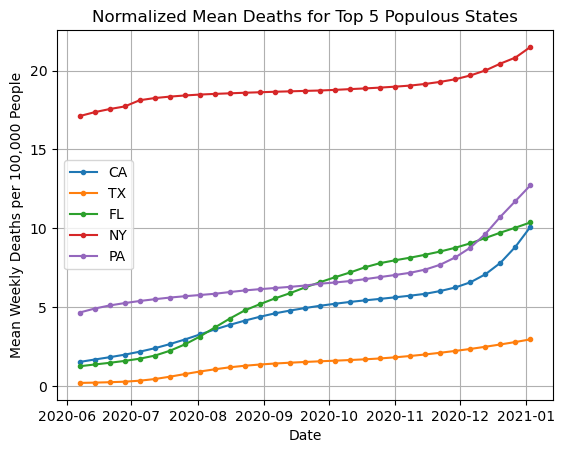

In [314]:
# Plot normalized mean deaths for top 5 populous states
fig, ax = plt.subplots()
for state in top_5_populous_states:
    state_data = gen_stats(state, covid_deaths_weekly, normalization_factor)
    ax.plot(state_data.index, state_data['mean'], label=state, marker='.')

ax.legend()
ax.title.set_text('Normalized Mean Deaths for Top 5 Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Weekly Deaths per 100,000 People')
ax.grid()
plt.show()

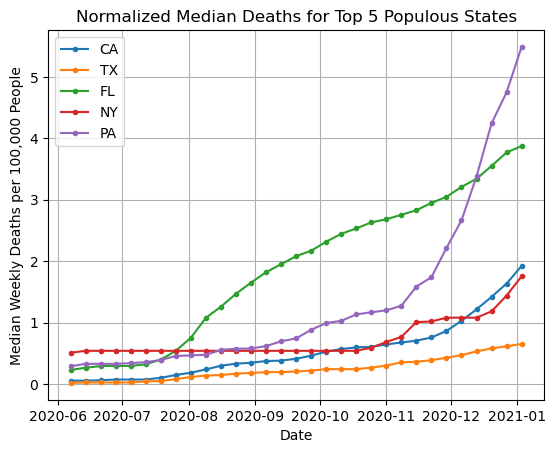

In [315]:
# Plot normalized median deaths for top 5 populous states
fig, ax = plt.subplots()
for state in top_5_populous_states:
    state_data = gen_stats(state, covid_deaths_weekly, normalization_factor)
    ax.plot(state_data.index, state_data['median'], label=state, marker='.')

ax.legend()
ax.title.set_text('Normalized Median Deaths for Top 5 Populous States')
ax.set_xlabel('Date')
ax.set_ylabel('Median Weekly Deaths per 100,000 People')
ax.grid()
plt.show()

In [316]:
# In New York, find the 5 counties with the highest mean deaths per 100,000 people
ny_data = covid_deaths_weekly[covid_deaths_weekly['State'] == 'NY']
ny_pop = ny_data['population'].sum()
ny_data = ny_data.drop(columns=['State', 'StateFIPS', 'population', 'countyFIPS'])
ny_data.set_index(['County Name'], inplace=True)
ny_data['mean'] = ny_data.mean(axis=1)
top_5_counties = ny_data.sort_values(by='mean', ascending=False).head().index

ny_data = ny_data.drop(columns='mean').T

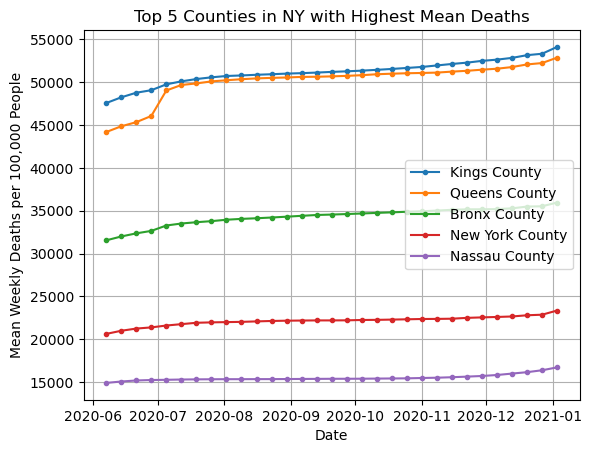

In [317]:
fig, ax = plt.subplots()
for county in top_5_counties:
    ax.plot(ny_data.index, ny_data[county], label=county, marker='.')

ax.legend()
ax.title.set_text('Top 5 Counties in NY with Highest Mean Deaths')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Weekly Deaths (raw data)')
ax.grid()
plt.show()

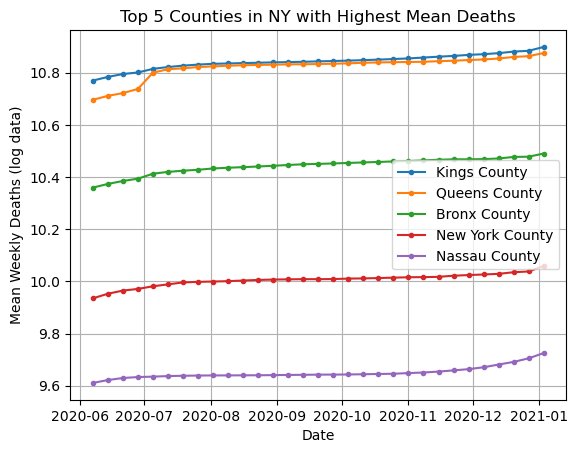

In [319]:
fig, ax = plt.subplots()
for county in top_5_counties:
    log_data = np.log1p(ny_data[county])
    ax.plot(ny_data.index, log_data, label=county, marker='.')

ax.legend()
ax.title.set_text('Top 5 Counties in NY with Highest Mean Deaths')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Weekly Deaths (log data)')
ax.grid()
plt.show()